In [54]:
!pip install zarr xarray xarray[io]
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install google-cloud-storage
!pip install scipy
#!pip install dask

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [55]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [56]:
'''
from dask.distributed import Client
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
client = Client(cluster)
cluster.scale(2)
'''

'\nfrom dask.distributed import Client\nfrom dask_gateway import GatewayCluster\n\ncluster = GatewayCluster()\nclient = Client(cluster)\ncluster.scale(2)\n'

In [57]:
from google.cloud import storage

def list_bucket_contents(bucket_name, folder_path=None):
    """Lists the contents of a folder within a Google Cloud Storage bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=folder_path)

    for blob in blobs:
        print(blob.name)

#list_bucket_contents("ohw23-oil")

In [58]:
fs = gcsfs.GCSFileSystem()
mapper = fs.get_mapper("gs://ohw23-oil/CSKS2.zarr")
data_array = xr.open_zarr(mapper,consolidated=True)

In [59]:
data_array

<xarray.Dataset>
Dimensions:      (band: 1, y: 8316, x: 11199)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.023e+05 4.023e+05 ... 5.702e+05 5.702e+05
  * y            (y) float64 7.834e+06 7.834e+06 ... 7.709e+06 7.709e+06
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 520, 1400), meta=np.ndarray>
    spatial_ref  int32 ...

In [60]:
#Example of setting a threshold on the data before doing histogram binning
threshold = 2000
ds = data_array.where(data_array < threshold)
ds = ds.fillna(threshold-1)



In [66]:
#Setup the histogram bins.  In this case, a bin size of size 10
bins = np.linspace(-1, threshold, 10)
print(bins)

#Function to process each chunk.  Example of histogram (not sure if this is the best/fastest way to do it)
def process_chunk(chunk):
  chunk = chunk.to_array()[0, :]
  #print(np.unique(chunk.to_numpy()))
  #chunk = gaussian_filter(chunk, sigma=5)  
  result = chunk.groupby_bins(chunk, bins).apply(xr.DataArray.count).fillna(0)
  result = result.fillna(0)
  return result

[-1.00000000e+00  2.21333333e+02  4.43666667e+02  6.66000000e+02
  8.88333333e+02  1.11066667e+03  1.33300000e+03  1.55533333e+03
  1.77766667e+03  2.00000000e+03]


In [67]:
def get_otsu_threshold(hist):
    hist = np.divide(hist.ravel(), hist.max())
 
    # Calculate centers of bins
    bin_mids = (bins[:-1] + bins[1:]) / 2.

    # Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]

    # Get the class means mu0(t)
    mean1 = np.cumsum(hist * bin_mids) / weight1
    # Get the class means mu1(t)
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Maximize the inter_class_variance function val
    index_of_max_val = np.argmax(inter_class_variance)

    threshold = bin_mids[:-1][index_of_max_val]
    return threshold

from scipy.ndimage import gaussian_filter
mask = np.zeros((8316, 11199), dtype=np.uint8) #Hack: hard coding dimensions
print(mask.shape)
#This will create N levels of chunk size (like a pyramid).  
def pyramid(data_array, levels=[500, 250, 100]):
  res = []  
  for chunksize in levels:
    data = data_array.chunk({'y':chunksize,'x':chunksize, 'band':1}).chunks
    ix = data['x']
    iy = data['y']

    idx = [sum(ix[:i]) for i in range(len(ix)+1)]
    idy = [sum(iy[:i]) for i in range(len(iy)+1)]

    for i in range(0, len(idx)-1, 1):
      tgt_x = xr.DataArray(np.arange(idx[i], idx[i+1]), dims="x")
      for j in range(0, len(idy)-1, 1):
        tgt_y = xr.DataArray(np.arange(idy[j], idy[j+1]), dims="y")
        chunk = data_array.isel(y=tgt_y, x=tgt_x, band=0)
        #if (chunk.sum()==0): continue
        histogram = process_chunk(chunk)
        print(f"{idx[i]}, {idy[j]} histogram: {histogram.to_numpy()}")
        #upper left corner of the chunk
        #size of the chunk (i.e. level)
        #histogram as a np array (I'm just more familiary with numpy)
        histogram = histogram.to_numpy()
        res.append({'x' : idx[i], 'y' : idy[j], 'chunksize' : chunksize, 'histogram' : histogram})
        if sum(histogram[1:]) == 0: continue
        th = get_otsu_threshold(histogram) #adaptively determine between threshold to get a binary mask
        print(f"Otsu threshold: {th}")
        chunk = chunk.to_array().to_numpy()[0,:] #assuming band_data is at index 0
        chunk = gaussian_filter(chunk, sigma=5)  #smo

        #chunk = ((chunk < th) & (chunk > 0)).astype(np.uint8)
        chunk = (chunk < th).astype(np.uint8)
        h, w = chunk.shape[-2:]
        x, y = idx[i], idy[j]
        mask[y:y+h, x:x+w] = chunk
        plt.imshow(mask)
        plt.show()
        ####
        # Do something with the result of the process_chunk function
        # 
        ####
  return res
        


(8316, 11199)


0, 0 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 500 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 1000 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 1500 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 2000 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 2500 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 3000 histogram: [250000.      0.      0.      0.      0.      0.      0.      0.      0.]
0, 3500 histogram: [248133     13     70    170    277    318    329    248    442]
Otsu threshold: 777.1666666666667


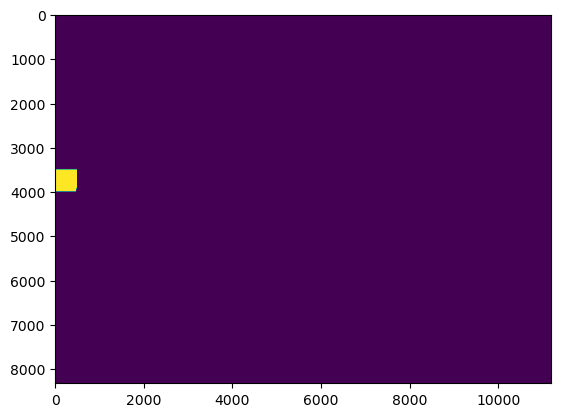

0, 4000 histogram: [212981    282   1730   4065   6181   7113   6148   4712   6788]
Otsu threshold: 554.8333333333334


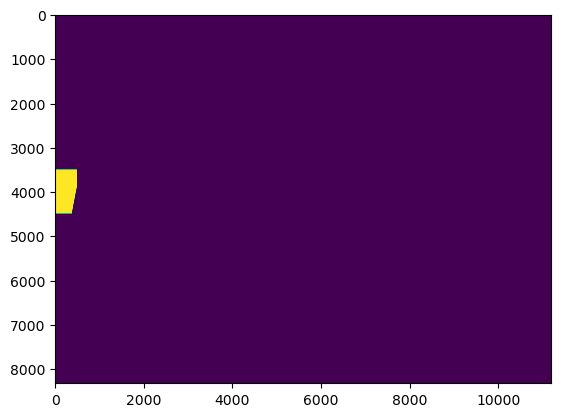

0, 4500 histogram: [165611    859   4723  10875  15838  16784  13541   9613  12156]
Otsu threshold: 554.8333333333334


In [ ]:
#This will be slow :(
histogram_dict = pyramid(ds, levels=[500])
plt.imshow(mask)